<a href="https://colab.research.google.com/github/maryooomi/Al-mass-first-project/blob/master/w1916669_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# __________CELL 1___________
#Imports the extra python packages we need
!pip -q install -U kagglehub shap joblib imbalanced-learn

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
import shap
import joblib

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

#sets the main projects settings
RANDOM_STATE = 42
TEST_SIZE = 0.2

GROUP_COL = "Patient_ID"
RAW_LABEL = "SepsisLabel"

HORIZON_HOURS = 6
USE_SUBSET_FOR_SPEED = True
N_PATIENTS_SUBSET = 5000

DROP_HOUR_IF_ICULOS = True
DROP_ULTRA_MISSING = True
MISSING_THRESHOLD = 0.98
CLEAN_OUTLIERS = True

In [ ]:
# __________CELL 2___________
#Downloads the prediction of sepsis data from kaggle using kagglehub.
path = kagglehub.dataset_download("salikhussaini49/prediction-of-sepsis")
csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
assert len(csv_files) > 0, "No CSV found"

df = pd.read_csv(csv_files[0])
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print("Original shape:", df.shape)
df[RAW_LABEL] = df[RAW_LABEL].astype(int)
print("Raw label distribution:\n", df[RAW_LABEL].value_counts(normalize=True))

Using Colab cache for faster access to the 'prediction-of-sepsis' dataset.
Original shape: (1552210, 43)
Raw label distribution:
 SepsisLabel
0    0.982015
1    0.017985
Name: proportion, dtype: float64


In [ ]:
# __________CELL 3___________
#create the early warning labels (future target)
df = df.sort_values([GROUP_COL, "ICULOS"]).copy()

#creates a helper function that looks ahead H hours for each patient
# and checks for sepsis happening soon
def future_max_excluding_now(s, H):
    rev = s.iloc[::-1]
    fut = rev.rolling(window=H, min_periods=1).max().shift(1)
    return fut.iloc[::-1]

df["SepsisInNextXH"] = (
    df.groupby(GROUP_COL)[RAW_LABEL]
      .transform(lambda s: future_max_excluding_now(s, HORIZON_HOURS))
      .fillna(0).astype(int)
)

df["SepsisInNext1H"] = (
    df.groupby(GROUP_COL)[RAW_LABEL]
      .shift(-1).fillna(0).astype(int)

)

df["SepsisEarlyWarning"] = (
    (df["SepsisInNextXH"] == 1) &
    (df["SepsisInNext1H"] == 0) &
    (df[RAW_LABEL] == 0)
).astype(int)

TARGET = "SepsisEarlyWarning"

print("\nSepsisInNextXH:\n", df["SepsisInNextXH"].value_counts())
print("\nSepsisEarlyWarning:\n", df[TARGET].value_counts(normalize=True))


SepsisInNextXH:
 SepsisInNextXH
0    1513147
1      39063
Name: count, dtype: int64

 SepsisEarlyWarning
0    0.992544
1    0.007456
Name: proportion, dtype: float64


In [ ]:
# __________CELL 4___________
# subset patients.
#uses the if use subset and randomly selects the N patients and then
# filters to only keep those patients
if USE_SUBSET_FOR_SPEED:
    rng = np.random.RandomState(RANDOM_STATE)
    keep = rng.choice(df[GROUP_COL].unique(), size=min(N_PATIENTS_SUBSET, df[GROUP_COL].nunique()), replace=False)
    df = df[df[GROUP_COL].isin(keep)].copy()
    print("\nSUBSET MODE ON:", df.shape, "| patients:", df[GROUP_COL].nunique())


SUBSET MODE ON: (191583, 46) | patients: 5000


In [ ]:
# __________CELL 5___________
# drops the ultra-missing columns
missing = df.drop(columns=[TARGET]).isna().mean()
if DROP_ULTRA_MISSING:
    drop_missing_cols = missing[missing >= MISSING_THRESHOLD].index.tolist()
    drop_missing_cols = [c for c in drop_missing_cols if c not in [TARGET, GROUP_COL]]
    if drop_missing_cols:
        df = df.drop(columns=drop_missing_cols)
    print("\nDropped", len(drop_missing_cols), "ultra-missing columns:", drop_missing_cols)


Dropped 6 ultra-missing columns: ['AST', 'Alkalinephos', 'Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen']


In [ ]:
# __________CELL 6___________
# cleans outliers
# defines a helper function where if we find an outlier we replace it with NaN
# later they get filled in by imputation
def set_out_of_range_to_nan(df_, col, low=None, high=None):
    if col not in df_.columns:
        return
    s = df_[col]
    mask = pd.Series(False, index=s.index)
    if low is not None:  mask |= (s < low)
    if high is not None: mask |= (s > high)
    df_.loc[mask, col] = np.nan

if CLEAN_OUTLIERS:
    set_out_of_range_to_nan(df, "FiO2", low=0.21, high=1.00)
    set_out_of_range_to_nan(df, "Temp", low=25.0, high=45.0)
    set_out_of_range_to_nan(df, "HR",   low=20.0, high=250.0)
    set_out_of_range_to_nan(df, "SBP",  low=40.0, high=300.0)
    set_out_of_range_to_nan(df, "DBP",  low=20.0, high=200.0)
    set_out_of_range_to_nan(df, "MAP",  low=20.0, high=250.0)
    set_out_of_range_to_nan(df, "Resp", low=1.0,  high=80.0)
    set_out_of_range_to_nan(df, "O2Sat",low=50.0, high=100.0)



In [ ]:
# __________CELL 7___________
# builds X, Y and blocks data leakage
LEAKAGE_COLS = ["SepsisLabel", "SepsisInNextXH", "SepsisInNext1H", "SepsisEarlyWarning"]
drop_cols = [TARGET] + LEAKAGE_COLS + [GROUP_COL]
if DROP_HOUR_IF_ICULOS and ("Hour" in df.columns) and ("ICULOS" in df.columns):
    drop_cols.append("Hour")

y = df[TARGET].astype(int)
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

assert all(c not in X.columns for c in LEAKAGE_COLS), "Leakage columns found in X"
print("\nX/y shapes:", X.shape, y.shape)


X/y shapes: (191583, 34) (191583,)


In [ ]:
# __________CELL 8___________
#splits the training/ testing data by patient (not by rows)
groups = df[GROUP_COL]
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [ ]:
# __________CELL 9___________
# preprocessing & training the two models
num_cols = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ]), num_cols)]
)

lr = Pipeline([("preprocess", preprocess),
               ("model", LogisticRegression(max_iter=5000, class_weight="balanced", n_jobs=-1))])

rf = Pipeline([("preprocess", preprocess),
               ("model", RandomForestClassifier(
                   n_estimators=200, max_depth=14, min_samples_leaf=20,
                   n_jobs=-1, random_state=RANDOM_STATE,
                   class_weight="balanced_subsample", max_features="sqrt", bootstrap=True
               ))])

def eval_model(name, model):
    proba = model.predict_proba(X_test)[:, 1]
    print(f"\n{name}")
    print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
    print("PR-AUC: ", round(average_precision_score(y_test, proba), 4))
    return proba

lr.fit(X_train, y_train)
lr_proba = eval_model("Logistic Regression", lr)

rf.fit(X_train, y_train)
rf_proba = eval_model("Random Forest", rf)



Logistic Regression
ROC-AUC: 0.7787
PR-AUC:  0.0441

Random Forest
ROC-AUC: 0.7498
PR-AUC:  0.0333



Chosen threshold (precision_constrained): 0.8043 | precision=0.200 recall=0.013


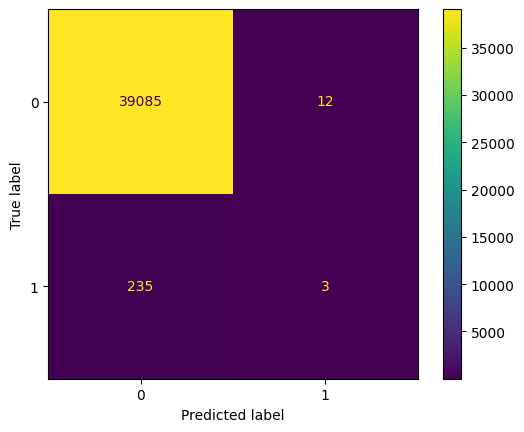

In [ ]:
# __________CELL 10___________
# choose an alert threshold and produce a confusion matrix
def pick_threshold_for_precision(y_true, proba, min_precision=0.20):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    valid = np.where(precision[:-1] >= min_precision)[0]
    if len(valid) == 0:
        f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
        best = np.argmax(f1)
        return thresholds[best], precision[best], recall[best], "best_f1_fallback"
    best = valid[np.argmax(recall[valid])]
    return thresholds[best], precision[best], recall[best], "precision_constrained"

thr, p, r, mode = pick_threshold_for_precision(y_test, rf_proba, min_precision=0.20)
print(f"\nChosen threshold ({mode}): {thr:.4f} | precision={p:.3f} recall={r:.3f}")

pred = (rf_proba >= thr).astype(int)
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
# __________CELL 11___________
# patient - level evaluation
test_patient_ids = df.iloc[test_idx][GROUP_COL].values
patient_df = pd.DataFrame({"patient_id": test_patient_ids, "y_true": y_test.values, "y_pred": pred})
patient_level = patient_df.groupby("patient_id").agg(true_any=("y_true","max"), pred_any=("y_pred","max")).reset_index()

print("\nPatient-level report:")
print(classification_report(patient_level["true_any"], patient_level["pred_any"], zero_division=0))


Patient-level report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       951
           1       1.00      0.08      0.15        49

    accuracy                           0.95      1000
   macro avg       0.98      0.54      0.56      1000
weighted avg       0.96      0.95      0.94      1000



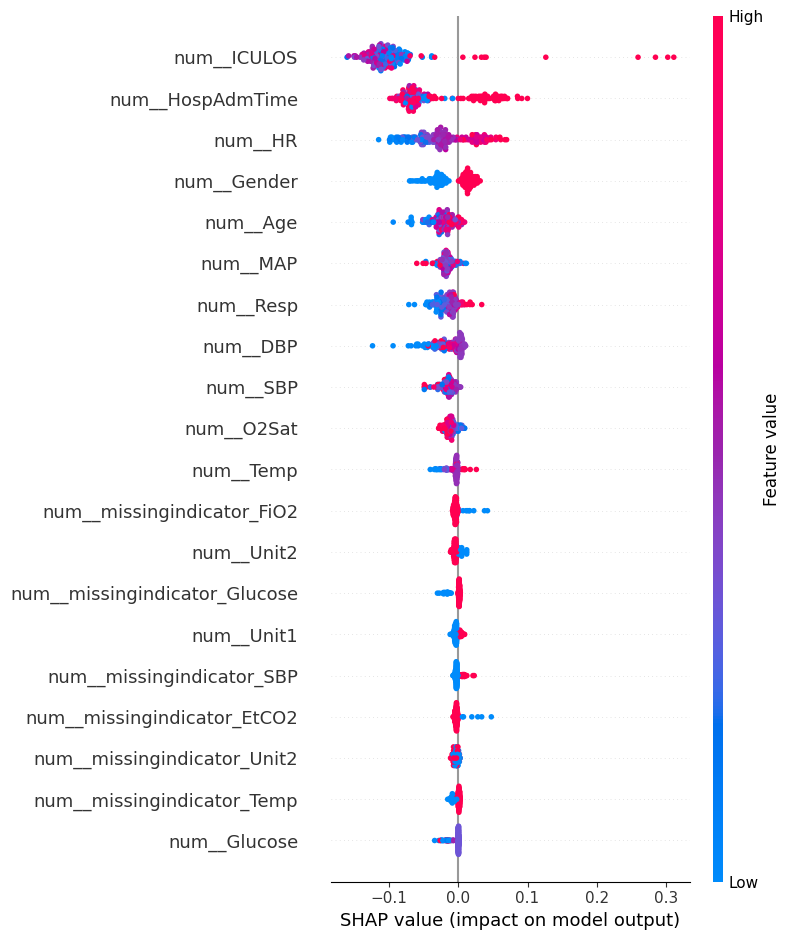

In [ ]:
# __________CELL 12___________
# SHAP explanations
fitted_preprocess = rf.named_steps["preprocess"]
fitted_model = rf.named_steps["model"]
X_test_transformed = fitted_preprocess.transform(X_test)

rng = np.random.RandomState(RANDOM_STATE)
n_shap = min(200, X_test_transformed.shape[0])
idx = rng.choice(X_test_transformed.shape[0], size=n_shap, replace=False)
X_shap = X_test_transformed[idx]
X_shap_dense = X_shap.toarray() if hasattr(X_shap, "toarray") else X_shap

try:
    feature_names = fitted_preprocess.get_feature_names_out()
except Exception:
    feature_names = None

explainer = shap.TreeExplainer(fitted_model)
sv = explainer.shap_values(X_shap_dense)

plt.figure()
if isinstance(sv, list):
    shap.summary_plot(sv[1], X_shap_dense, feature_names=feature_names, show=True)
else:
    shap.summary_plot(sv[:, :, 1], X_shap_dense, feature_names=feature_names, show=True)




In [ ]:
# __________CELL 13___________
# save the model
bundle = {
    "base_model": rf,
    "chosen_threshold": float(thr),
    "config": {
        "TARGET": TARGET, "GROUP_COL": GROUP_COL, "HORIZON_HOURS": HORIZON_HOURS,
        "USE_SUBSET_FOR_SPEED": USE_SUBSET_FOR_SPEED, "N_PATIENTS_SUBSET": N_PATIENTS_SUBSET,
        "RANDOM_STATE": RANDOM_STATE, "TEST_SIZE": TEST_SIZE
    }
}
joblib.dump(bundle, "sepsis_rf_bundle.pkl")
print("\nSaved: sepsis_rf_bundle.pkl")

results = pd.DataFrame([
    {"Model":"Logistic Regression","ROC_AUC":roc_auc_score(y_test, lr_proba),"PR_AUC":average_precision_score(y_test, lr_proba)},
    {"Model":"Random Forest","ROC_AUC":roc_auc_score(y_test, rf_proba),"PR_AUC":average_precision_score(y_test, rf_proba),
     "Threshold":thr,"Precision_at_threshold":p,"Recall_at_threshold":r}
])
results.to_csv("model_results.csv", index=False)
print("Saved: model_results.csv")
display(results)


Saved: sepsis_rf_bundle.pkl
Saved: model_results.csv


,Model,ROC_AUC,PR_AUC,Threshold,Precision_at_threshold,Recall_at_threshold
0,Logistic Regression,0.778730,0.044142,NaN,NaN,NaN
1,Random Forest,0.749758,0.033256,0.804332,0.2,0.012605


In [ ]:
#References
#https://pypi.org/project/kagglehub/
#https://stackoverflow.com/questions/62450055/problem-in-reading-products-csv-file-with-pandas-python
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
#https://pandas.pydata.org/docs/reference/api/pandas.Series.shift.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html
#https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
#https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#I used chatGPT and deepseek to help me debug any code issues, and improving my code redability. All the final design decisions, code changes and results are tested and validated by me in google collab.